C:\Users\utabo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\utabo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


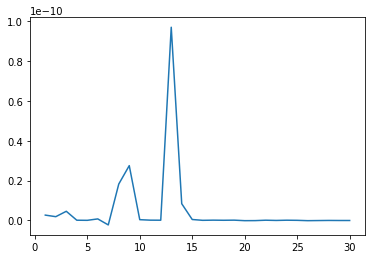

-0.7690998029138458

In [3]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import time
# %%
def get_L(n_array):
    L = n_array.sum()
    return L

def get_K(b_array):
    K = b_array.sum()
    return K

def get_u(c, p):
    sigma = p['sigma']
    u = (c**(1-sigma) -1)/(1-sigma)
    return u

def u_prime(c, p):
    sigma = p['sigma']
    u_prime = c**(-sigma)
    return u_prime

    return u_prime
def get_w(K, L, p):
    A = p['A']
    alpha = p['alpha']
    w = (1-alpha)*A*(K/L)**alpha
    return w

def get_r(K, L, p):
    alpha = p['alpha']
    A = p ['A']
    delta = p['delta']
    r = alpha*A*(L/K)**(1-alpha) - delta

    return r

def get_Y(K, L, p):
    alpha = p['alpha']
    A = p['A']
    Y = A*K**alpha*L**(1-alpha)
    return Y

def get_c(b, p, f):
    n = p['n']
    w = f['w'](f['K'](b), f['L'](n), p)
    r = f['r'](f['K'](b), f['L'](n), p)

    c = np.zeros(3)

    c[0] = w*p['n'][0] - b[0]
    c[1] = w*p['n'][1] + (1+r)*b[0]-b[1]
    c[2] = w*p['n'][2] + (1+r)*b[1]

    return c

# %%
def equations_ss_b(b, p, f):
    """ Takes in a guess for b and a dictionary of functions
    f and a dictionary of elemtns p."""
    n = p['n']
    w = f['w'](f['K'](b), f['L'](n), p)
    r = f['r'](f['K'](b), f['L'](n), p)

    e1_l = f['u_p'](w-b[0], p)
    e1_r = p['beta']*(1+r)*f['u_p'](w+(1+r)*b[0]-b[1], p)

    e2_l = f['u_p'](w+(1+r)*b[0]-b[1], p)
    e2_r = p['beta']*(1+r)*f['u_p']((1+r)*b[1]+0.2*w, p)

    e1 = e1_l - e1_r
    e2 = e2_l - e2_r

    return [e1, e2]

def get_ss(bvec_guess, p, f):
    start_time = time.clock()
    n = p['n']
    F = lambda b: equations_ss_b(b, p, f)

    sol = root(F, bvec_guess, tol=p['tol'])

    b_ss = sol.x
    c_ss = f['c'](b_ss, p, f)
    w_ss = f['w'](f['K'](b_ss), f['L'](n), p)
    r_ss = f['r'](f['K'](b_ss), f['L'](n), p)

    K_ss = f['K'](b_ss)
    L_ss = f['L'](n)
    Y_ss = f['Y'](K_ss, L_ss, p)
    C_ss = c_ss.sum()

    EulErr_ss = equations_ss_b(b_ss, p, f)
    RCer_ss = Y_ss - C_ss - K_ss*(p['delta'])

    ss_time = time.clock() - start_time

    ss_output = {'b_ss':b_ss, 'c_ss':c_ss, 'w_ss':w_ss \
                , 'r_ss':r_ss, 'K_ss':K_ss, 'Y_ss':Y_ss \
                , 'C_ss':C_ss, 'EulErr_ss':EulErr_ss, 'RCerr_ss': \
                RCer_ss, 'ss_time':ss_time}
    return ss_output



# %%
def equation_tpi_3_first(b_32, b_21, v, p, f):
    w_1 = v['w_guess'][0]
    w_2 = v['w_guess'][1]
    r_1 = v['r_guess'][0]
    r_2 = v['r_guess'][1]

    e_1 = f['u_p'](w_1+(1+r_1)*b_21-b_32, p)
    e_r = p['beta']*(1+r_2)*f['u_p']((1+r_2)*b_32+0.2*w_2, p)

    e = e_r - e_1
    return e

def equations_tpi_3(b, v, p, f, T_curr):
    w_1 = v['w_guess'][T_curr-2]
    w_2 = v['w_guess'][T_curr-1]
    w_3 = v['w_guess'][T_curr]
    r_1 = v['r_guess'][T_curr-2]
    r_2 = v['r_guess'][T_curr-1]
    r_3 = v['r_guess'][T_curr]

    e_l_1 = f['u_p'](w_1-b[0], p)
    e_r_1 = p['beta']*(1+r_2)*f['u_p'](w_2 + (1+r_2)*b[0]-b[1], p)

    e_l_2 = f['u_p'](w_2+(1+r_2)*b[0] - b[1], p)
    e_r_2 = p['beta']*(1+r_3)*f['u_p']((1+r_3)*b[1]+0.2*w_3, p)

    e1 = e_r_1 - e_l_1
    e2 = e_r_2 - e_l_2

    return [e1, e2]



def tpi_solve(v, p, f, T_curr):
    if T_curr == 1:
        F = lambda b: equation_tpi_3_first(b, v['b_start'][0], v, p, f)
        sol = root(F, v['b_start'][1])
        v['b_matrix'][1, 1]  = sol.x
        v['euler_matrix'][1, 1] = equation_tpi_3_first(sol.x, v['b_start'][0], v, p, f)
    elif T_curr == variables['T']:
        T_temp = T_curr-1
        b_start = np.array([v['b_matrix'][T_temp-2, 0], v['b_matrix'][T_temp-2, 1]])
        F = lambda b: equations_tpi_3(b, v, p, f, T_temp)
        sol = root(F, b_start)
        v['b_matrix'][T_curr-1, 0] = sol.x[0]
        v['b_matrix'][T_curr, 1] = sol.x[1]

        v['euler_matrix'][T_curr-1, :] = equations_tpi_3(sol.x, v, p, f, T_temp)

    else:
        b_start = np.array([v['b_matrix'][T_curr-2, 0], v['b_matrix'][T_curr-2, 1]])
        F = lambda b: equations_tpi_3(b, v, p, f, T_curr)
        sol = root(F, b_start)
        v['b_matrix'][T_curr-1, 0] = sol.x[0]
        v['b_matrix'][T_curr, 1] = sol.x[1]

        v['euler_matrix'][T_curr-1, :] = equations_tpi_3(sol.x, v, p, f, T_curr)


def get_CY_matrix(v, p, f):
    k_matrix = v['K_guess']
    b_matrix = v['b_matrix'][:-1,:]

    n = p['n']

    w = f['w'](f['K'](b_matrix), f['L'](b_matrix), p)
    r = f['r'](f['K'](b_matrix), f['L'](b_matrix), p)

    c = np.zeros((v['T'], 3))

    c[:,0] = w*p['n'][0] - b_matrix[:,0]
    c[:,1] = w*p['n'][1] + (1+r)*b_matrix[:,0]-b_matrix[:,1]
    c[:,2] = w*p['n'][2] + (1+r)*b_matrix[:,1]


    L = functions['L'](n)
    Y = functions['Y'](k_matrix, L, p)

    C = c.sum(axis=1)

    return C, Y

def update_k(v, p, f):
    C, Y = get_CY_matrix(v, p, f)
    K_old = v['K_guess']
    b_matrix = v['b_matrix'][:-1, :]
    K_new = b_matrix.sum(axis=1)
    v['RCer_vector'] = Y - C - K_new + (1-p['delta'])*K_old
    v['error'].append(np.dot(K_new-K_old, K_new-K_old))
    K_final = K_new*v['xi'] + K_old*(1-v['xi'])
    v['K_guess'] = K_final
    v['w_guess'] = f['w'](K_final, f['L'](p['n']), p)
    v['r_guess'] = f['r'](K_final, f['L'](p['n']), p)
    return v

def TPI(v, p, f):
    while v['error'][-1] > v['tol']:
        for i in range(1, v['T']+1):
            tpi_solve(v, p, f, i)
        v = update_k(v, p, f)
    return v
# %%
def TPI_init(p, f, ss):
    v = dict()
    v['T'] = 30
    v['xi'] = 0.8
    v['b_start'] = np.array([ss['b_ss'][0]*.8, ss['b_ss'][1]*1.1])
    v['K_guess'] = np.linspace(f['K'](v['b_start']), ss['K_ss'], v['T'])
    v['RCer_vector'] = np.zeros_like(v['K_guess'])

    v['w_guess'] = f['w'](v['K_guess'], f['L'](p['n']), p)
    v['r_guess'] = f['r'](v['K_guess'], f['L'](p['n']), p)

    v['b_matrix'] = np.zeros((v['T']+1, 2))
    v['b_matrix'][0,:] = v['b_start']

    v['euler_matrix'] = np.zeros_like(v['b_matrix'])
    v['euler_matrix'][0,:] = np.array(ss['EulErr_ss'])
    v['tol'] = 1e-9
    v['error']=[1]

    return v

# %%
functions = {'L':get_L, 'K':get_K, 'r':get_r, 'u':get_u, 'u_p':u_prime,
             'w':get_w,'c':get_c, 'Y':get_Y}

params = {'beta':0.96**(20), 'delta': 1- (1-0.05)**20, 'sigma':3 , \
          'A':1, 'alpha':0.35, 'n':np.array([1, 1, 0.2]), 'tol':None}

ss_output = get_ss(np.array([.1,.1]), params, functions)
# %%
variables = TPI_init(params, functions, ss_output)
variables = TPI(variables, params, functions)
# %%
variables['error']
# %%
plt.plot(np.linspace(1, 30,30), variables['euler_matrix'].max(axis=1)[:-1])
plt.show()
# %%
variables['RCer_vector'].max()
# %%
